<h1># Open again in assistant editor to compare</h1>

In [136]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.jpeg import jpegdec, jpegenc
from scipy import optimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')

lighthouse = lighthouse - 128.0
bridge = bridge - 128.0
flamingo = flamingo - 128.0

In [138]:
image = lighthouse # flamingo breaks variation of LBT and DWT
size_lim = 40810

<h1>Raw</h1>

Size = 524288, Err = 0.0


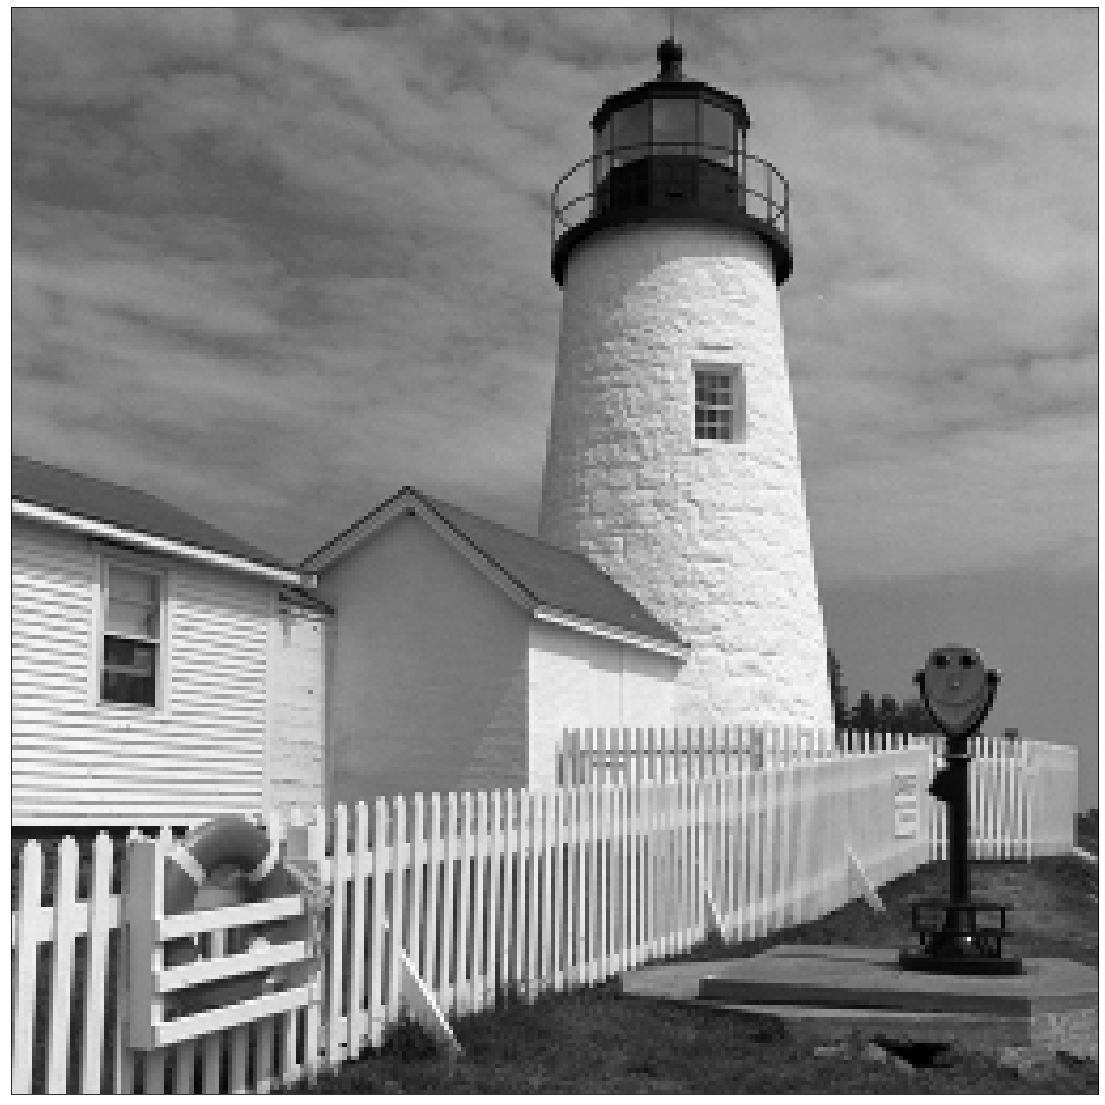

In [139]:
fig, ax = plt.subplots(figsize=(20, 20))

plot_image(image, ax=ax)
ax.set(yticks=[], xticks=[])

# fig.savefig("figs/l_raw.pdf")

print(f'Size = {256*256*8}, Err = {np.std(0):.4}')

<h1>JPEG (slow)</h1>

In [140]:
%%script echo skipping

def error(qstep: int) -> int:

    Z, h = jpegenc(image, qstep, opthuff=True, dcbits=16, log=False)
    size = Z[:, 1].sum()
    return np.sum((size - size_lim)**2)

opt_step = optimize.minimize_scalar(error, method="bounded", bounds=(4, 128)).x
vlc, hufftab = jpegenc(image, opt_step, opthuff=True, dcbits=10, log=False)

Z = jpegdec(vlc, opt_step, hufftab=hufftab, dcbits=10, log=False)

fig, ax = plt.subplots(figsize=(20, 20))
plot_image(Z, ax=ax)
ax.set(yticks=[], xticks=[])

# fig.savefig("figs/l_jpeg_opthuff_dc16bits.pdf")


print(f'Size = {vlc[:, 1].sum()}, Step = {opt_step:.4} (check bounds), Err = {np.std(Z - image):.4}')

skipping


<h1>DWT</h1>

In [141]:

from compression import DWTCompression, LBTCompression

Size = 40819, Step = 27.8 (check bounds), Err = 8.487


[[], []]

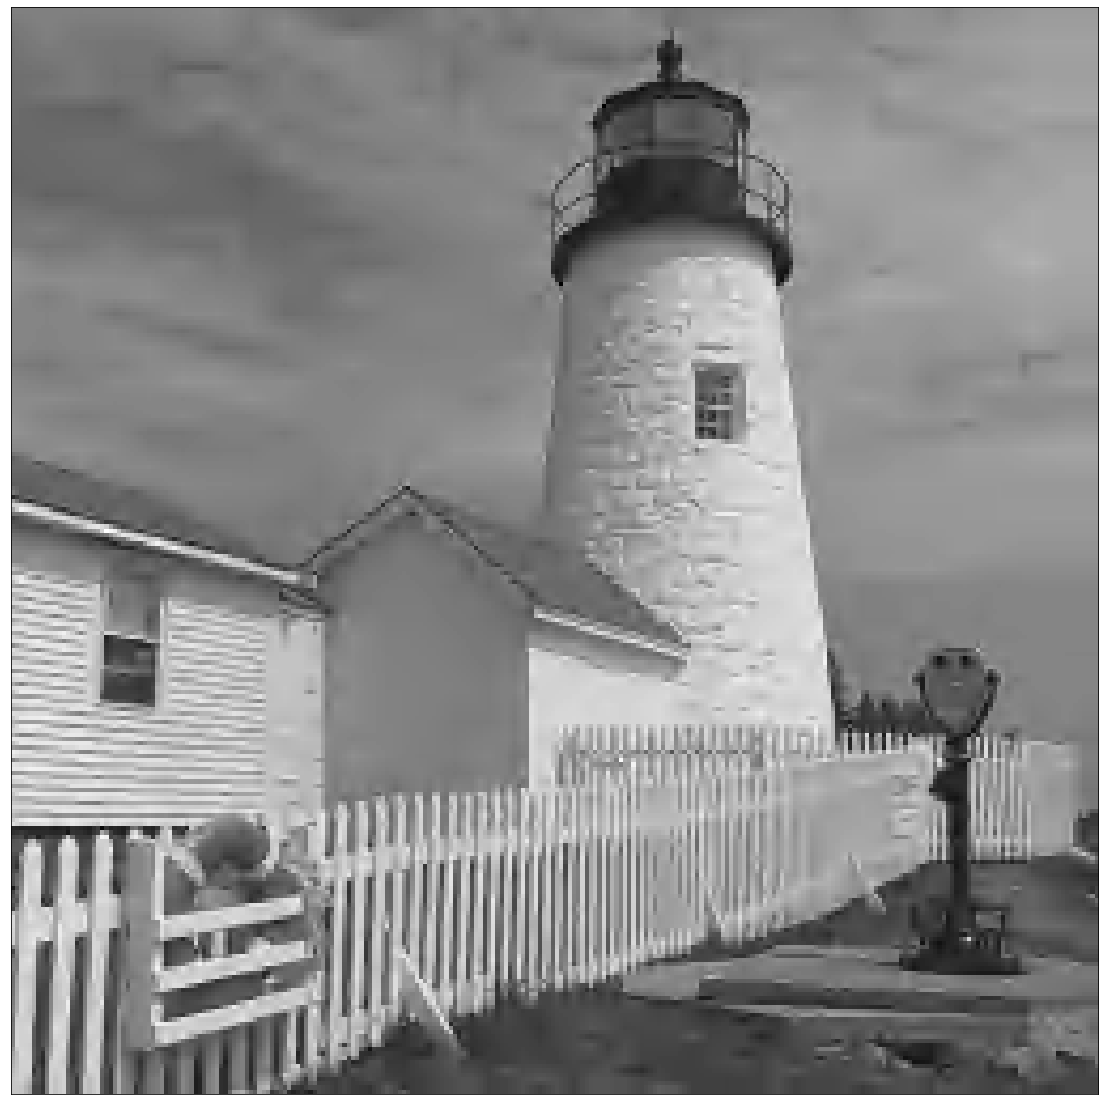

In [142]:
fig, ax = plt.subplots(figsize=(20, 20))

DWT = DWTCompression(5)

Y1 = DWT.compress(image)

(vlc, hufftab), qs = DWT.opt_encode(Y1, size_lim=size_lim, root2=False)

Y = DWT.decode(vlc, qstep=qs, hufftab=hufftab, root2=False)

Z = DWT.decompress(Y)

plot_image(Z, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Step = {qs:.4} (check bounds), Err = {np.std(Z - image):.4}')

ax.set(yticks=[], xticks=[])

# fig.savefig("figs/l_dwt_opthuff.pdf")

<h1>DWT with Intermediary sqrt(2) Q Steps</h1>

Size = 40808, Step = 1.644 (check bounds), Err = 8.447


[[], []]

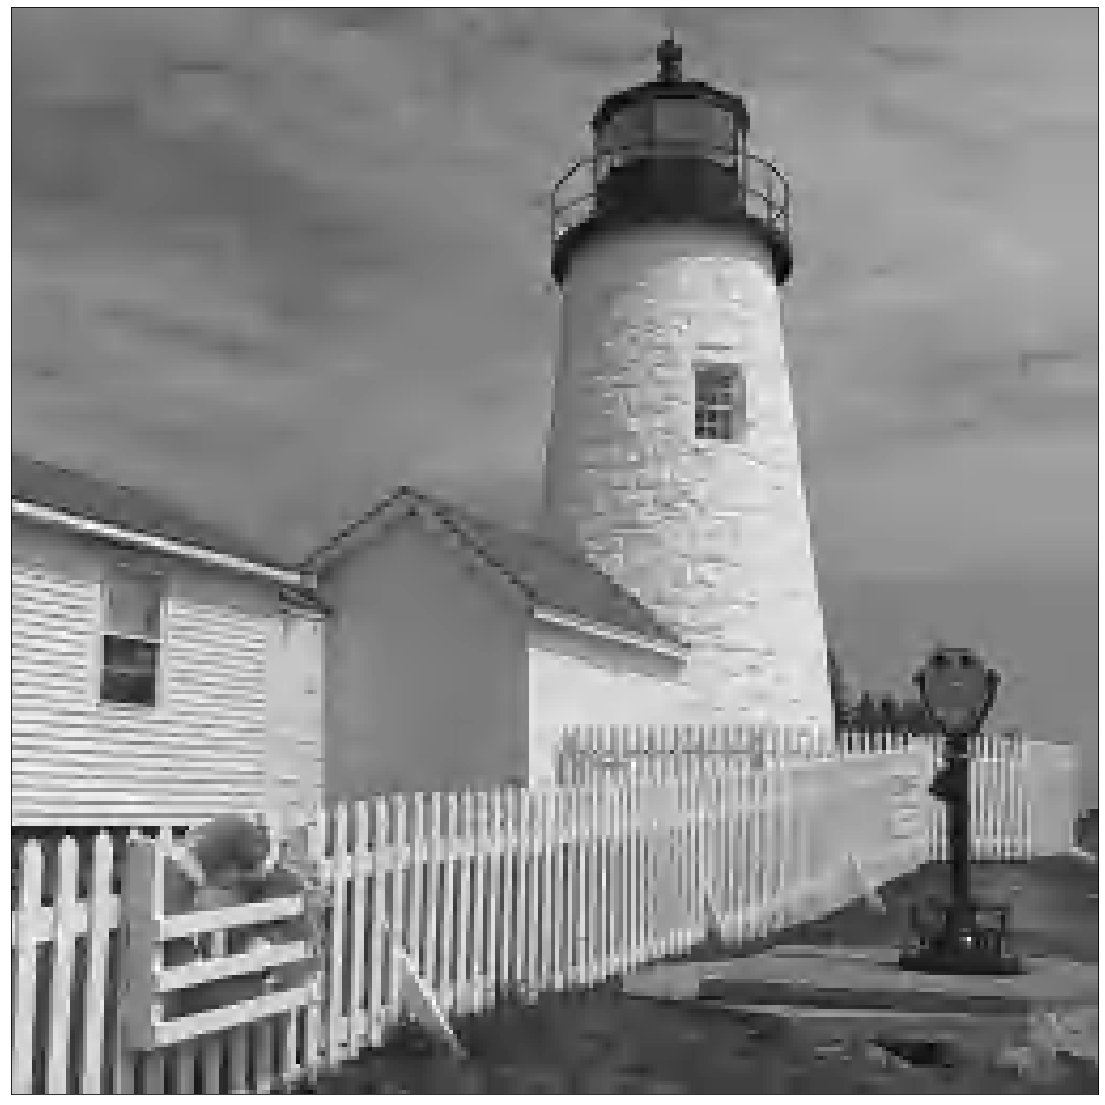

In [143]:
fig, ax = plt.subplots(figsize=(20, 20))

DWT = DWTCompression(5)

Y = DWT.compress(image)

(vlc, hufftab), qs = DWT.opt_encode(Y, size_lim=size_lim)

Y = DWT.decode(vlc, qstep=qs, hufftab=hufftab)

Z = DWT.decompress(Y)

plot_image(Z, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Step = {qs:.4} (check bounds), Err = {np.std(Z - image):.4}')

ax.set(yticks=[], xticks=[])

# fig.savefig("figs/l_dwt_opthuff_root2.pdf")


<h1>LBT</h1>

Size = 40806, Step = 51.27 (check bounds), Err = 7.818


[[], []]

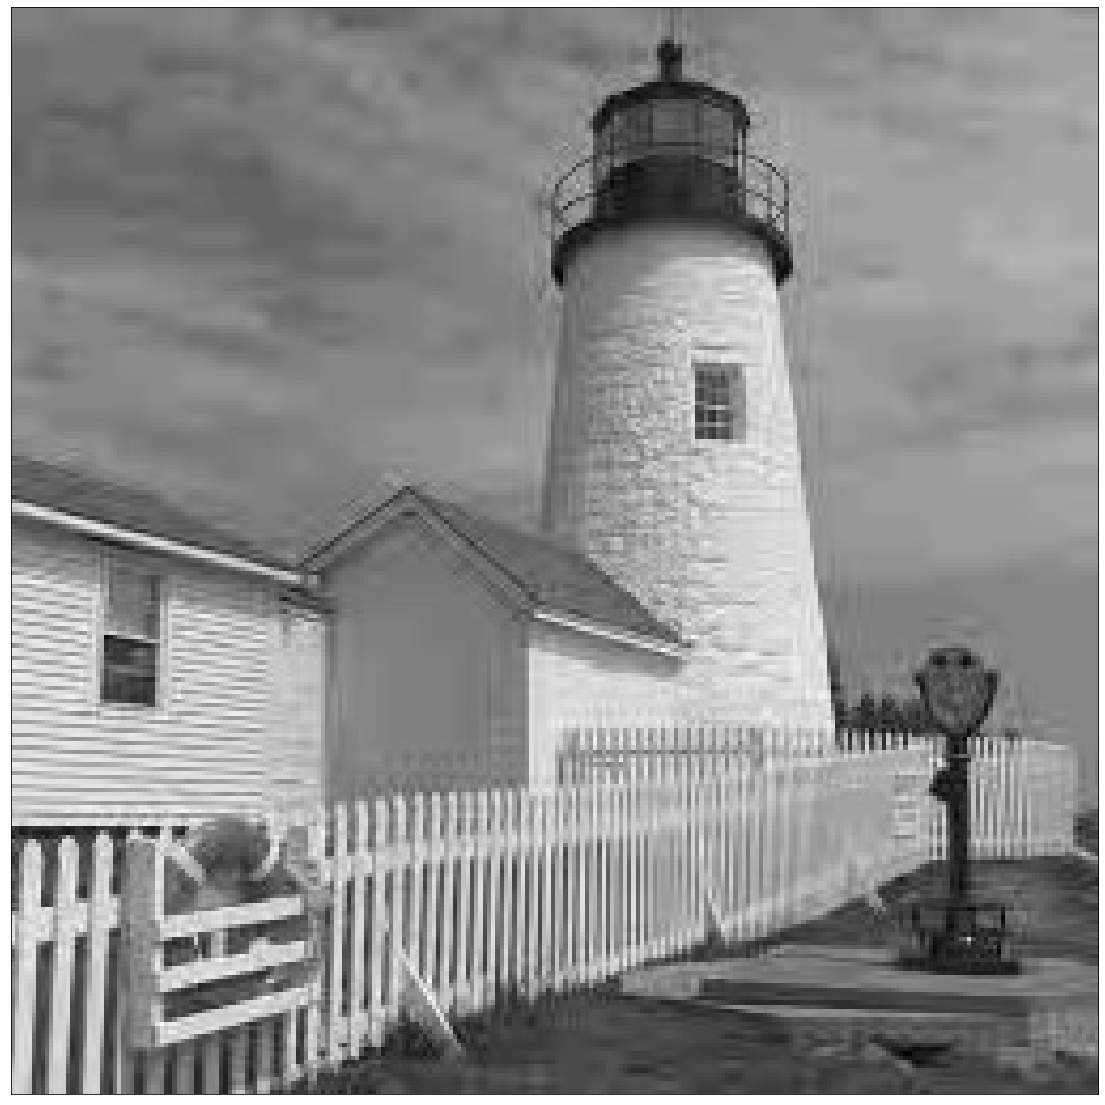

In [144]:
scheme = LBTCompression(s=1.3)

fig, ax = plt.subplots(figsize=(20, 20))

Y = scheme.compress(image)
(vlc, hufftab), qs = scheme.opt_encode(Y, size_lim=size_lim)
header = (hufftab, qs)

Y = scheme.decode(vlc, qstep=header[1], hufftab=header[0])
Z = scheme.decompress(Y)

plot_image(Z, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Step = {qs:.4} (check bounds), Err = {np.std(Z - image):.4}')

ax.set(yticks=[], xticks=[])

# fig.savefig("figs/l_lbt_opthuff.pdf")

<h1>LBT with Quantisation Gradient</h1>

Size = 40805, Step = 1.053 (check bounds), Err = 49.91


[[], []]

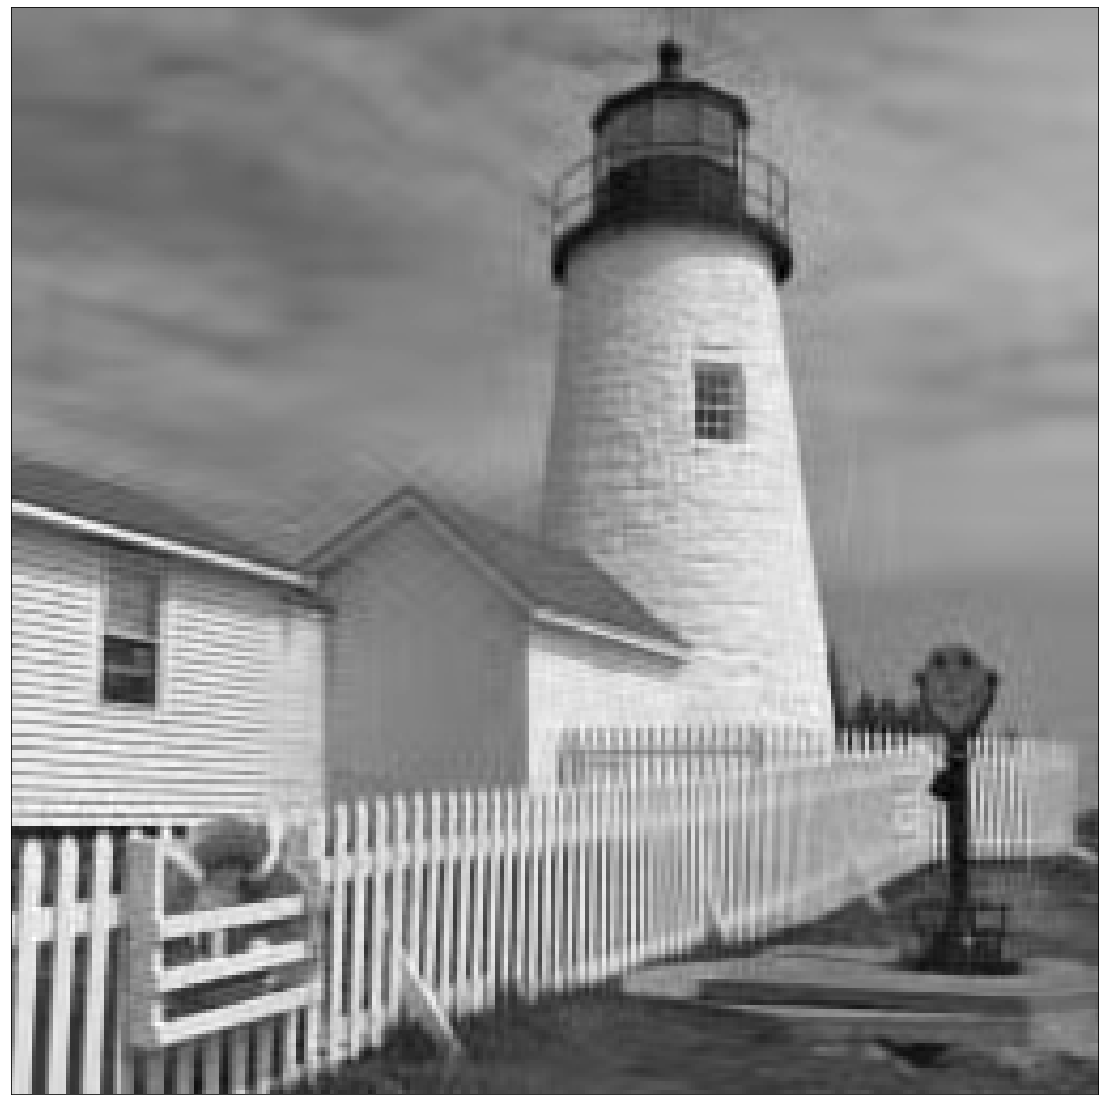

In [145]:
# Quantisation gradient top left to bottom right, apparently just lightly high passes but introduces massive RMS error
# unreliable. M = 8 for flamingo, = 16 for lighthouse

M = 16

scheme = LBTCompression(s=1.3, N=M)

fig, ax = plt.subplots(figsize=(20, 20))

Y = scheme.compress(image)
(vlc, hufftab), qs = scheme.opt_encode(Y, size_lim=size_lim, M=M, quant_grad=True)
header = (hufftab, qs)

Y = scheme.decode(vlc, qstep=header[1], M=M, hufftab=header[0], quant_grad=True)
Z = scheme.decompress(Y)
plot_image(Z, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Step = {qs:.4} (check bounds), Err = {np.std(Z - image):.4}')

ax.set(yticks=[], xticks=[])

# fig.savefig("figs/l_lbt_opthuff_qgrad.pdf")